In [20]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff

gas_analysis_data = pd.read_csv("gas_analysis.csv")
contract_chunks_base_data = pd.read_csv("contracts_chunks_stats.csv")

In [26]:
# Check that all tx aggregation of gas per chunk matches gas_analysis_data (it must)
tx_sum_gas = contract_chunks_base_data.groupby("tx").aggregate({"gas_used": "sum"}).reset_index()
diff = tx_sum_gas.merge(gas_analysis_data[["tx", "31bytechunker_gas"]], on="tx")
if ((diff['gas_used'] - diff['31bytechunker_gas']) != 0).any():
    raise Exception("chunks total gas doesn't match 31bytechunker gas")

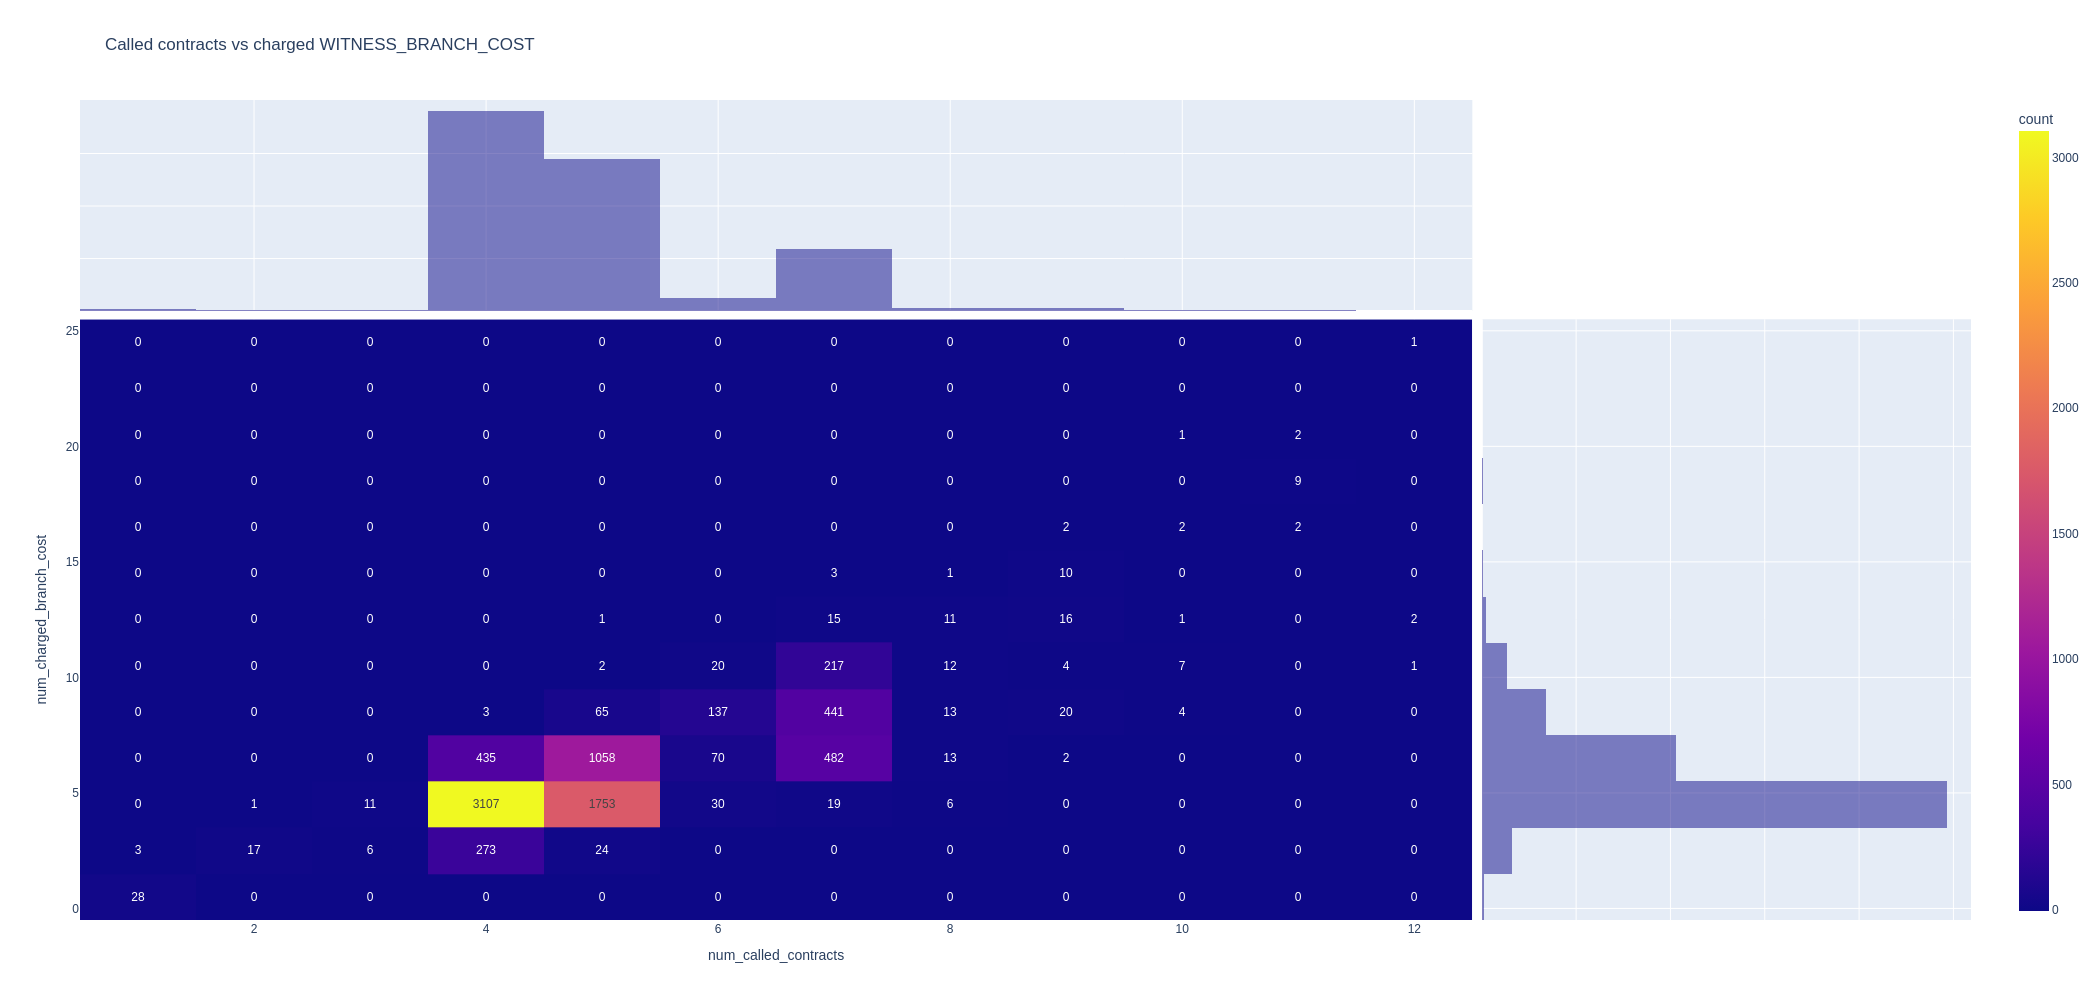

|      | tx                                                                 |   num_charged_branch_cost |
|-----:|:-------------------------------------------------------------------|--------------------------:|
| 3570 | 0x0a55c13a15bb2479a11e831c4ec442397f946cb8c0bb780b13a8566ec7c69cf4 |                        25 |
| 4818 | 0x0dc7122fc3c7ea2ac7129300f5b4b1ff0de069f581d6ec78cc18186d31ba26d6 |                        20 |
| 7831 | 0x162dcb57d83abf3e66ae104bd29ec0550f9aeea0a60adbbd0ac24136b6bfae55 |                        20 |
| 2715 | 0x07d5984a8d1cb39ae68f564bf8d42c20f1aadd1aabce3d5d0e0a83c9d49e2b9b |                        20 |
| 6051 | 0x112d31924242f59ca2f573b2daa354ff31b1c845cb402a7697ec447dec535a50 |                        19 |


In [55]:
WITNESS_BRANCH_COST = 1900

# Create dataframe with: tx, num_contracts, avg_bytes_used_per_chunk, code_gas_used, charged_branch_cost_count, receipt_gas
df = contract_chunks_base_data.groupby("tx")
df = df.aggregate({"contract_addr": 'nunique', "bytes_used": 'mean', "gas_used": ['sum', lambda x: (x > WITNESS_BRANCH_COST).sum()]}).reset_index()

df2 = pd.DataFrame()
df2['tx'] = df['tx']
df2['num_called_contracts'] = df[('contract_addr', 'nunique')]
df2['avg_bytes_used_per_chunk'] = df[('bytes_used', 'mean')]
df2['code_gas_used'] = df[('gas_used', 'sum')]
df2['num_charged_branch_cost'] = df[('gas_used', '<lambda_0>')]

fig = px.density_heatmap(
    df2, 
    title="Called contracts vs charged WITNESS_BRANCH_COST",
    x="num_called_contracts", 
    y="num_charged_branch_cost", 
    marginal_x="histogram", 
    marginal_y="histogram", 
    nbinsx=20, 
    nbinsy=20,
    text_auto=True,
    width=1500,
    height=1000)
fig.show()

jj = df2.sort_values(by=["num_charged_branch_cost"], ascending=False)
print(jj[['tx', 'num_charged_branch_cost']].head().to_markdown())

In [ ]:
# tx, to, contractAddr, chunkNumber, bytes_used, gas_used

#// Chunk stats (on average per tx):
#//     - Accessed # code-chunks and would've charged {} code-access gas.
#//     - Charged {} WITNESS_BRANCH_COSTs
#//     - Executed {} bytes (i.e: instruction bytes), and paid for {} bytes (i.e: chunks bytes)
#//
#// Txs on average involved executing {} contracts.